In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
import cv2
import random
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms.functional as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchsummary import summary
from skimage.metrics import structural_similarity as ssim
from statistics import mean

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# import zipfile
# with zipfile.ZipFile('/content/drive/MyDrive/archive (7).zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/')

In [6]:
folder_path = "/kaggle/input/grayscale-images/landscape Images/color"

files = os.listdir(folder_path)

image_files = [f for f in files if f.endswith(('jpg'))]

color_images = []

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path)
    color_images.append(image)

In [7]:
folder_path = "/kaggle/input/grayscale-images/landscape Images/gray"

files = os.listdir(folder_path)

image_files = [f for f in files if f.endswith(('jpg'))]

bw_images = []

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = cv2.imread(image_path)
    bw_images.append(image)

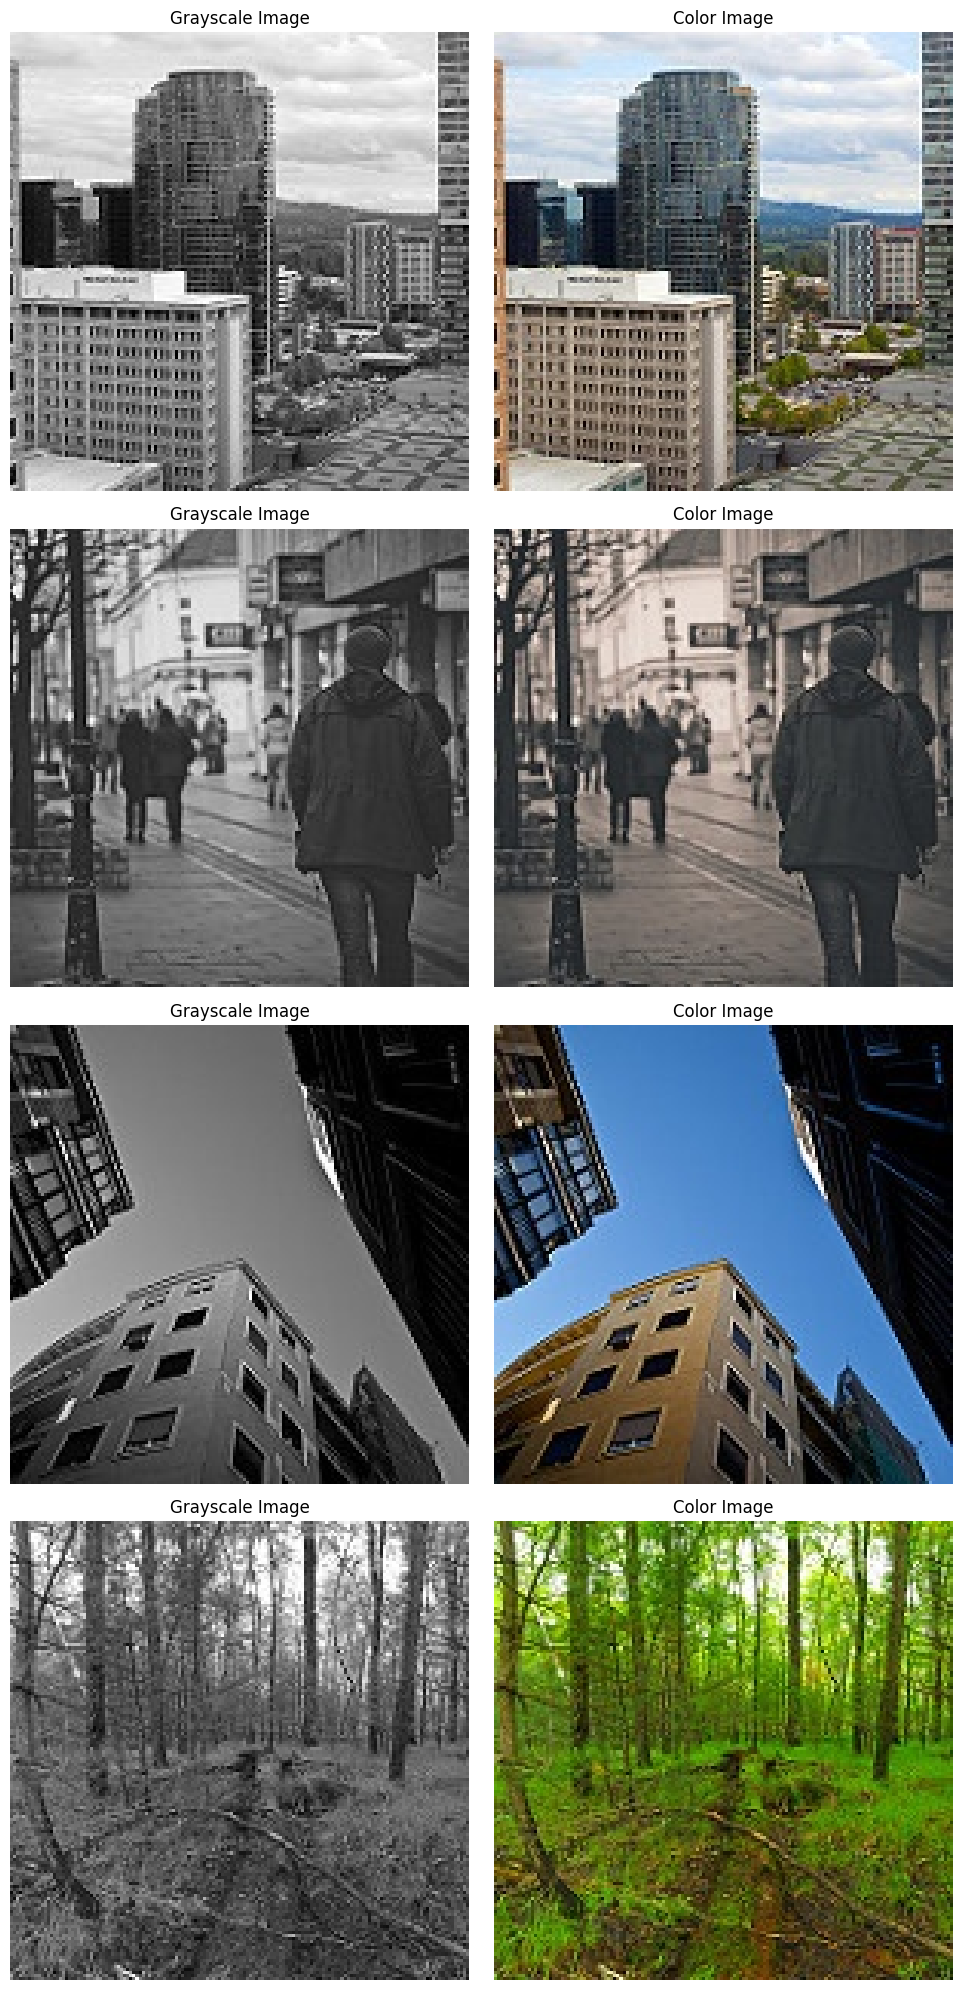

In [8]:
def plot_comparison(grayscale_images, color_images):
    num_images = min(len(grayscale_images), len(color_images))
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 5*num_images))

    for i in range(num_images):
        # Plot grayscale image
        axes[i, 0].imshow(grayscale_images[i], cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Grayscale Image')

        # Plot color image
        axes[i, 1].imshow(color_images[i])
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Color Image')

    plt.tight_layout()
    plt.show()

gray=[]
color=[]
for i in range(4):
    number = random.randint(0,7128)
    gray.append(bw_images[number])
    color.append(color_images[number])
plot_comparison(gray, color)


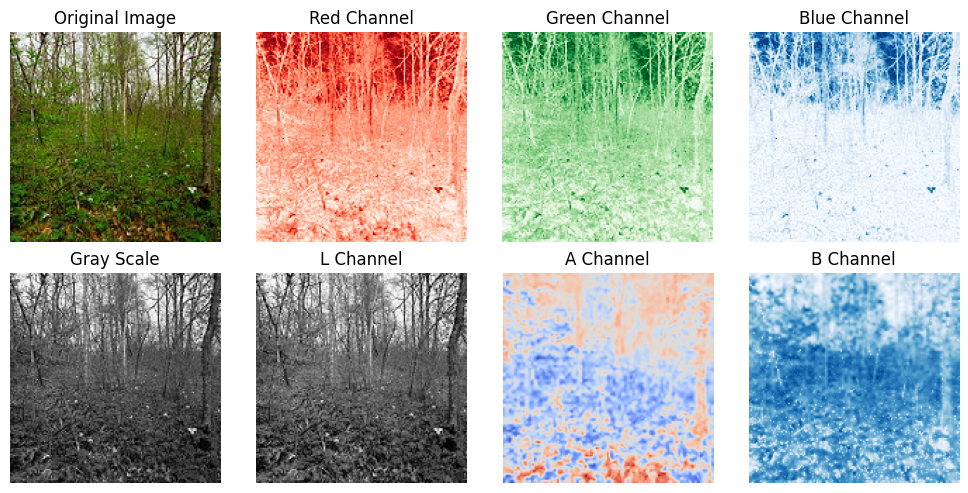

In [9]:
num = random.randint(0,7128)
image = np.array(color_images[num])
image1 = np.array(bw_images[num])
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]
lab_image = color_images[num].convert('LAB')
l_channel, a_channel, b_channel = lab_image.split()

plt.figure(figsize=(10, 5))
plt.subplot(2, 4, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(image1)
plt.title('Gray Scale')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(l_channel, cmap='gray')
plt.title('L Channel')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(a_channel, cmap='coolwarm')
plt.title('A Channel')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(b_channel, cmap='Blues')
plt.title('B Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
print(type(np.array(color_images[0])))
print(type(bw_images[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
color = []
for image in color_images:
    image = np.array(image)
    color.append(image)

In [12]:
print(type(color))

<class 'list'>


In [13]:
X_train, X_temp, Y_train, Y_temp = train_test_split(bw_images, color_images, test_size=0.3, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [14]:
print("Number of elements in X_train_gray:", len(X_train))
print("Number of elements in X_val_gray:", len(X_val))
print("Number of elements in X_test_gray:", len(X_test))
print("Number of elements in X_train_color:", len(Y_train))
print("Number of elements in X_val_color:", len(Y_val))
print("Number of elements in X_test_color:", len(Y_test))

Number of elements in X_train_gray: 4990
Number of elements in X_val_gray: 1070
Number of elements in X_test_gray: 1069
Number of elements in X_train_color: 4990
Number of elements in X_val_color: 1070
Number of elements in X_test_color: 1069


In [15]:
lab_image = color_images[0].convert('LAB')
l_channel, a_channel, b_channel = lab_image.split()
print("labspace", lab_image)
print(l_channel)
print(a_channel)
print(b_channel)


labspace <PIL.Image.Image image mode=LAB size=150x150 at 0x7D43C8027BB0>
<PIL.Image.Image image mode=L size=150x150 at 0x7D43C8027AF0>
<PIL.Image.Image image mode=L size=150x150 at 0x7D43C8026DD0>
<PIL.Image.Image image mode=L size=150x150 at 0x7D43C8027490>


In [16]:
height = color_images[0].height
width = color_images[0].width
print("Size of the image is: ", height, " x ", width)

Size of the image is:  150  x  150


In [17]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150)),
])

l_channel = []
for i in X_test:
    i = cv2.cvtColor(i, cv2.COLOR_BGR2LAB)
    bw_lchannel, bw_achannel, bw_bchannel = cv2.split(i)
    BWL_tensor = transform(bw_lchannel)
    l_channel.append(BWL_tensor)

# Define a custom dataset class
class ColorDataset(Dataset):
    def __init__(self, bw_images, color_images, transform=None):
        self.bw_images = bw_images
        self.color_images = color_images
        self.transform = transform

    def __len__(self):
        return len(self.bw_images)

    def __getitem__(self, idx):
        bw_image = self.bw_images[idx]
        color_image = self.color_images[idx]

        # Extract A and B channels from color image
        lab_image = color_image.convert('LAB')
        l_channel, a_channel, b_channel = lab_image.split()

        if self.transform:
            bw_image = self.transform(bw_image)
            a_channel = self.transform(a_channel)
            b_channel = self.transform(b_channel)

        ab_channels = torch.stack([a_channel, b_channel])

        return bw_image, ab_channels

# Create datasets and dataloaders
train_dataset = ColorDataset(X_train, Y_train, transform=transform)
val_dataset = ColorDataset(X_val, Y_val, transform=transform)
test_dataset = ColorDataset(X_test, Y_test, transform=transform)

actual_ab_channels = []
for i in test_dataset:
  bw_images, ab_channels = i
  actual_ab_channels.append(ab_channels)
print("Size of AB-channels: ", len(actual_ab_channels))
print("shape: ", actual_ab_channels[0].shape)

train_loader = DataLoader(train_dataset, batch_size=80, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=80, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=80, num_workers=2)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Size of AB-channels:  1069
shape:  torch.Size([2, 1, 150, 150])


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

class ColorizationResNet(nn.Module):
    def __init__(self):
        super(ColorizationResNet, self).__init__()
        self.initial_conv = nn.Conv2d(3, 64, kernel_size=9, padding=4)

        # Stacking Residual Blocks
        self.res_blocks = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64)
        )

        # Upsampling Layers
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((150, 150)),
            nn.Conv2d(32, 2, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = F.relu(self.initial_conv(x))
        x = self.res_blocks(x)
        x = self.upsample(x)
        return x

# Create the model instance
model = ColorizationResNet()

# Criterion and optimizer can be set as per your choice
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

Using device: cuda


ColorizationResNet(
  (initial_conv): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size

In [20]:
summary(model, (3, 150, 150), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]          15,616
            Conv2d-2         [-1, 64, 150, 150]          36,864
       BatchNorm2d-3         [-1, 64, 150, 150]             128
            Conv2d-4         [-1, 64, 150, 150]          36,864
       BatchNorm2d-5         [-1, 64, 150, 150]             128
     ResidualBlock-6         [-1, 64, 150, 150]               0
            Conv2d-7         [-1, 64, 150, 150]          36,864
       BatchNorm2d-8         [-1, 64, 150, 150]             128
            Conv2d-9         [-1, 64, 150, 150]          36,864
      BatchNorm2d-10         [-1, 64, 150, 150]             128
    ResidualBlock-11         [-1, 64, 150, 150]               0
           Conv2d-12         [-1, 64, 150, 150]          36,864
      BatchNorm2d-13         [-1, 64, 150, 150]             128
           Conv2d-14         [-1, 64, 1

In [21]:
# Train the model

train_loss = []
val_loss = []
predicted_ab_channel = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    mse_train_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.squeeze(2)
        targets = targets.permute(0,1,2,3)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    train_loss.append(running_train_loss / len(train_loader))

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    mse_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (inputs_val, targets_val) in enumerate(val_loader):
            inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)
            outputs_val = model(inputs_val)
            targets_val = targets_val.squeeze(2)
            targets_val = targets_val.permute(0,1,2,3)
            vali_loss = criterion(outputs_val, targets_val)
            running_val_loss += vali_loss.item()
    val_loss.append(running_val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]}, Val Loss: {val_loss[-1]}")

# Evaluate the model
model.eval()
running_test_loss = 0.0
mse_test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicted_ab_channel.append(outputs)
        targets = targets.squeeze(2)
        targets = targets.permute(0,1,2,3)
        test_loss = criterion(outputs, targets)
        running_test_loss += loss.item()
        mse_test_loss += torch.mean((outputs - targets) ** 2).item()
test_loss = running_test_loss / len(test_loader)
test_mse = mse_test_loss/len(test_loader)
print(f"Test Loss: {test_loss}")

Epoch 1/10, Train Loss: 0.021471404063973635, Val Loss: 0.0035300870159907
Epoch 2/10, Train Loss: 0.0033040199916632403, Val Loss: 0.0033022237808576654
Epoch 3/10, Train Loss: 0.0031657357485817064, Val Loss: 0.0032828445213713814
Epoch 4/10, Train Loss: 0.003036308752757216, Val Loss: 0.003176450213816549
Epoch 5/10, Train Loss: 0.0029886194526971806, Val Loss: 0.003951366691450987
Epoch 6/10, Train Loss: 0.003004786203659716, Val Loss: 0.002865697174066944
Epoch 7/10, Train Loss: 0.0029208407042518496, Val Loss: 0.0027180278141583714
Epoch 8/10, Train Loss: 0.0028552881900280242, Val Loss: 0.002935560420155525
Epoch 9/10, Train Loss: 0.00282947012844185, Val Loss: 0.003019320229733629
Epoch 10/10, Train Loss: 0.002804106367485864, Val Loss: 0.002771524346566626
Test Loss: 0.0031582822557538748


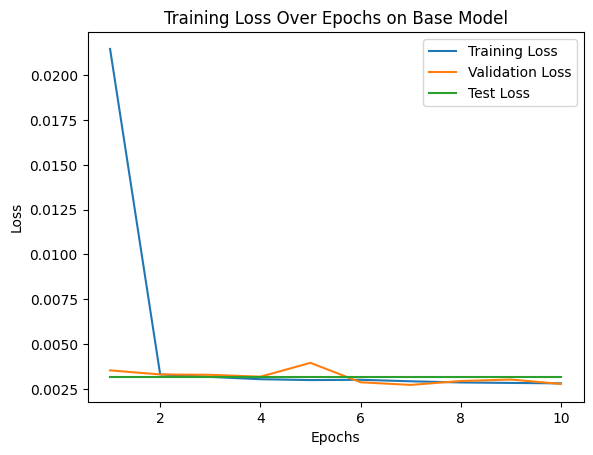

In [22]:
#plotting the loss graph
epoc = range(1, len(train_loss) + 1)
testing_loss = [test_loss] * 10

plt.plot(epoc, train_loss, label='Training Loss')
plt.plot(epoc, val_loss, label='Validation Loss')
plt.plot(epoc, testing_loss, label='Test Loss')

plt.title('Training Loss Over Epochs on Base Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
torch.save(model.state_dict(),'keshavap_ss675_neemageo_resnet.h5')

In [24]:
#converting the predicted list from batches to lists
pred_ab_channel = []
for i in predicted_ab_channel:
  for j in i:
    pred_ab_channel.append(j)

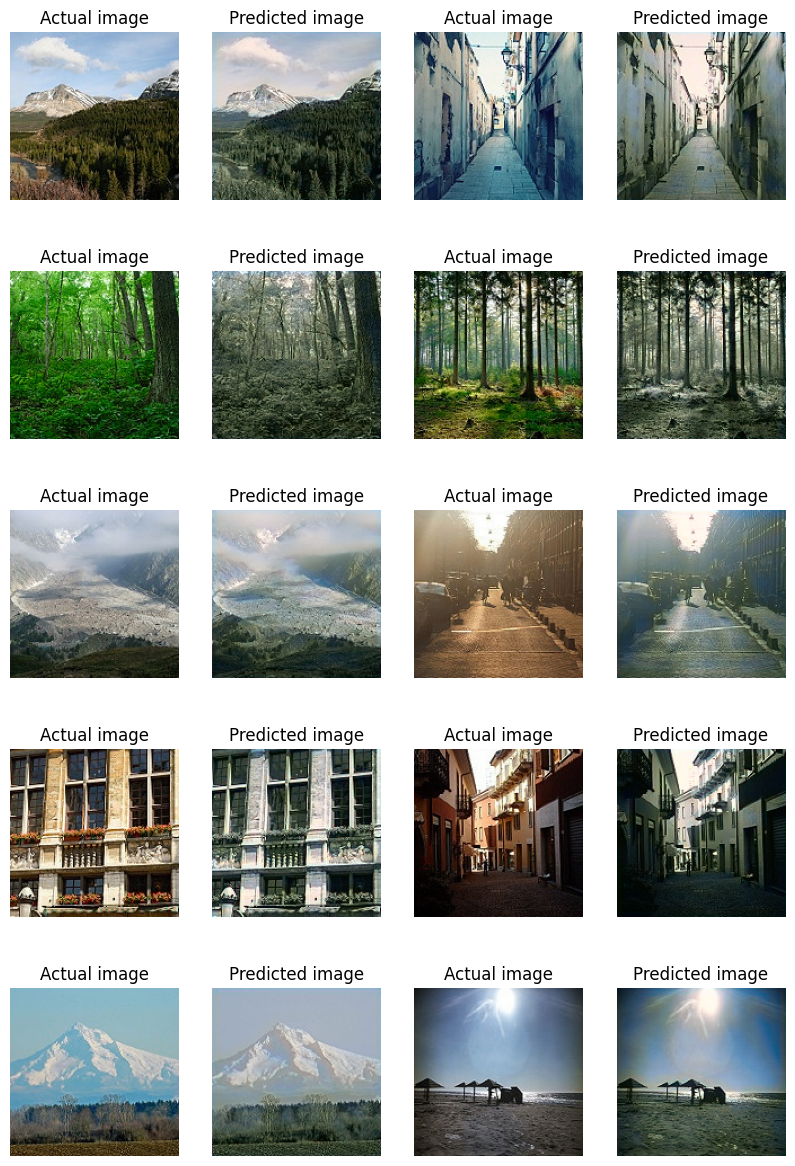

In [28]:
# Display random 10 predicted images in comparission with original images
original_image = []
predicted_image = []
for i in range(10):
  number = random.randint(0,1069)
  L_tensor = l_channel[number]
  actual_AB_tensor = actual_ab_channels[number]
  actual_A_tensor = actual_AB_tensor[0]
  actual_B_tensor = actual_AB_tensor[1]
  pred_ab_tensor = pred_ab_channel[number]
  pred_a_tensor = pred_ab_tensor[0]
  pred_b_tensor = pred_ab_tensor[1]

  # Define the shape of the image
  image_size = (150, 150)

  # Convert tensors to PIL images
  L_image = T.to_pil_image(L_tensor)
  actual_A_image = T.to_pil_image(actual_A_tensor)
  actual_B_image = T.to_pil_image(actual_B_tensor)
  pred_A_image = T.to_pil_image(pred_a_tensor)
  pred_B_image = T.to_pil_image(pred_b_tensor)

  # Resize images to the desired size
  L_image = T.resize(L_image, image_size)
  actual_A_image = T.resize(actual_A_image, image_size)
  actual_B_image = T.resize(actual_B_image, image_size)
  pred_A_image = T.resize(pred_A_image, image_size)
  pred_B_image = T.resize(pred_B_image, image_size)

  # Merge L, A, and B channels into a LAB image
  actual_LAB_image = Image.merge("LAB", (L_image, actual_A_image, actual_B_image))
  pred_LAB_image = Image.merge("LAB", (L_image, pred_A_image, pred_B_image))

  # Convert LAB image to RGB
  actual_RGB_image = actual_LAB_image.convert("RGB")
  pred_RGB_image = pred_LAB_image.convert("RGB")
  original_image.append(actual_RGB_image)
  predicted_image.append(pred_RGB_image)

# Display or save the image
plt.figure(figsize=(10, 15))
plt.subplot(5,4,1)
plt.imshow(original_image[0])
plt.title('Actual image')
plt.axis('off')

plt.subplot(5,4,2)
plt.imshow(predicted_image[0])
plt.title('Predicted image')
plt.axis('off')

plt.subplot(5,4,3)
plt.imshow(original_image[1])
plt.title('Actual image')
plt.axis('off')

plt.subplot(5,4,4)
plt.imshow(predicted_image[1])
plt.title('Predicted image')
plt.axis('off')

plt.subplot(5,4,5)
plt.imshow(original_image[2])
plt.title('Actual image')
plt.axis('off')

plt.subplot(5,4,6)
plt.imshow(predicted_image[2])
plt.title('Predicted image')
plt.axis('off')

plt.subplot(5,4,7)
plt.imshow(original_image[3])
plt.title('Actual image')
plt.axis('off')

plt.subplot(5,4,8)
plt.imshow(predicted_image[3])
plt.title('Predicted image')
plt.axis('off')

plt.subplot(5,4,9)
plt.imshow(original_image[4])
plt.title('Actual image')
plt.axis('off')

plt.subplot(5,4,10)
plt.imshow(predicted_image[4])
plt.title('Predicted image')
plt.axis('off')

plt.subplot(5,4,11)
plt.imshow(original_image[5])
plt.title('Actual image')
plt.axis('off')

plt.subplot(5,4,12)
plt.imshow(predicted_image[5])
plt.title('Predicted image')
plt.axis('off')

plt.subplot(5,4,13)
plt.imshow(original_image[6])
plt.title('Actual image')
plt.axis('off')

plt.subplot(5,4,14)
plt.imshow(predicted_image[6])
plt.title('Predicted image')
plt.axis('off')

plt.subplot(5,4,15)
plt.imshow(original_image[7])
plt.title('Actual image')
plt.axis('off')

plt.subplot(5,4,16)
plt.imshow(predicted_image[7])
plt.title('Predicted image')
plt.axis('off')

plt.subplot(5,4,17)
plt.imshow(original_image[8])
plt.title('Actual image')
plt.axis('off')

plt.subplot(5,4,18)
plt.imshow(predicted_image[8])
plt.title('Predicted image')
plt.axis('off')

plt.subplot(5,4,19)
plt.imshow(original_image[9])
plt.title('Actual image')
plt.axis('off')

plt.subplot(5,4,20)
plt.imshow(predicted_image[9])
plt.title('Predicted image')
plt.axis('off')

plt.show()

In [29]:
# Compare the predicted image with the original image
SSIM = []
for i in range(10):
  image1 = original_image[i]
  image2 = predicted_image[i]
  imageA = cv2.cvtColor(np.array(image1), cv2.COLOR_BGR2GRAY)
  imageB = cv2.cvtColor(np.array(image2), cv2.COLOR_BGR2GRAY)
  s = ssim(imageA, imageB)
  SSIM.append(s)

print(f"SSIM: {mean(SSIM)}")

SSIM: 0.9854504811243482


In [30]:
def compare_histograms(channel1, channel2):
    hist1 = cv2.calcHist([channel1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([channel2], [0], None, [256], [0, 256])
    score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return score
hist_score = []
for i in range(10):
  image1 = original_image[i]
  image2 = predicted_image[i]
  imageA = cv2.cvtColor(np.array(image1), cv2.COLOR_BGR2GRAY)
  imageB = cv2.cvtColor(np.array(image2), cv2.COLOR_BGR2GRAY)
  score = compare_histograms(imageA, imageB)
  hist_score.append(score)

print(f"Histogram comparision: {mean(hist_score)}")

Histogram comparision: 0.8622328010037718
